In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

## masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
         0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
         0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
         1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
         0.33863009])
## total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses) #=59.9
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33

## UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
## projected separation divided by effective radius from Georgiev
UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667, 
                                  0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
                                  1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
                                  0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
                                  1.22266667])

UGC8638_rperps_norms =  np.array([])

NGC4605_rperps_norms =  np.array([])
## physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
#UGC8638_rperps = UGC7369_rperps_norms*UGC7369_R_e
#NGC4605_rperps = UGC7369_rperps_norms*UGC7369_R_e

## a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

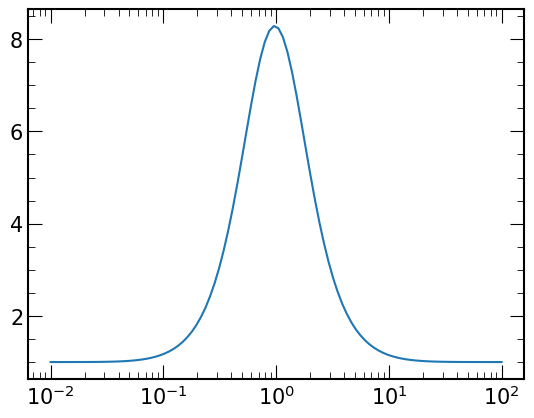

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.861173391342163
5 0.1
finished until t = 0.0 1.3257601261138916


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 6.808866262435913
finished until t = 1.0 15.490308046340942
finished until t = 1.5 26.684877395629883
finished until t = 2.0 40.322736501693726
finished until t = 2.5 57.21293091773987
finished until t = 3.0 76.2207612991333
finished until t = 3.5 97.40576601028442
finished until t = 4.0 121.13333678245544
finished until t = 4.5 146.63455057144165
finished until t = 5.0 174.49571537971497
finished until t = 5.5 204.3150351047516
finished until t = 6.0 236.2295436859131
finished until t = 6.5 270.4789762496948
finished until t = 7.0 305.78236627578735
finished until t = 7.5 343.10241627693176
finished until t = 8.0 382.8269131183624
finished until t = 8.5 423.8892250061035
finished until t = 9.0 467.4131851196289
finished until t = 9.5 512.3239588737488
finished until t = 10.0 559.3339257240295


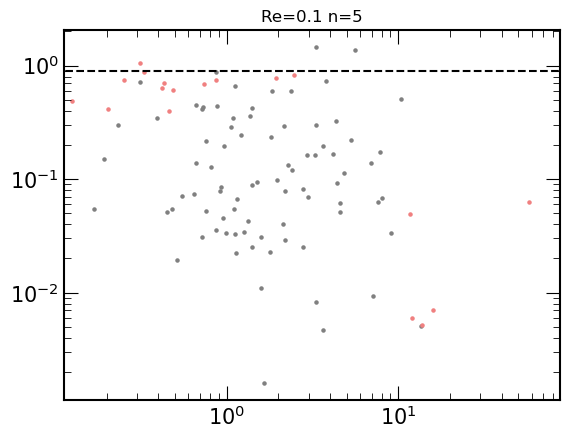

Calculating NFW Energies and Weights


<ipython-input-3-ee763b17153f>:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
8.395389795303345
5 0.6
finished until t = 0.0 0.8243734836578369
finished until t = 0.5 6.214176177978516
finished until t = 1.0 16.10622763633728
finished until t = 1.5 31.099910259246826
finished until t = 2.0 50.30478644371033
finished until t = 2.5 74.08203721046448
finished until t = 3.0 102.2948853969574
finished until t = 3.5 135.04237174987793
finished until t = 4.0 171.142254114151
finished until t = 4.5 212.7053484916687
finished until t = 5.0 258.02519369125366
finished until t = 5.5 308.1997606754303
finished until t = 6.0 362.5823333263397
finished until t = 6.5 421.40105533599854
finished until t = 7.0 484.4002149105072
finished until t = 7.5 551.2361571788788
finished until t = 8.0 622.6136922836304
finished until t = 8.5 698.6206045150757
finished until t = 9.0 777.9384787082672
finished until t = 9.5 861.1040859222412
finished until t = 10.0 948.2871763706207


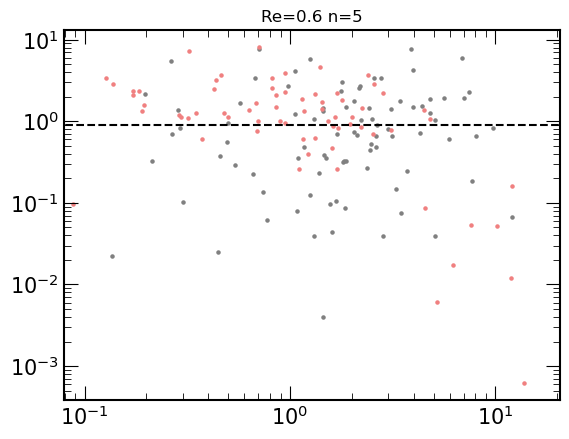

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.508614301681519
5 1.1
finished until t = 0.0 0.8314487934112549
finished until t = 0.5 6.40115761756897
finished until t = 1.0 16.90435767173767
finished until t = 1.5 32.607752084732056
finished until t = 2.0 53.00021839141846
finished until t = 2.5 78.33169889450073
finished until t = 3.0 108.63352656364441
finished until t = 3.5 143.44768953323364
finished until t = 4.0 183.792986869812
finished until t = 4.5 228.69614267349243
finished until t = 5.0 278.54785799980164
finished until t = 5.5 333.49862718582153
finished until t = 6.0 393.4449779987335
finished until t = 6.5 458.34652400016785
finished until t = 7.0 528.1508626937866
finished until t = 7.5 603.3132874965668
finished until t = 8.0 683.3222432136536
finished until t = 8.5 768.4020936489105
finished until t = 9.0 859.4050605297089
finished until t = 9.5 954.8987219333649
finished until t = 10.0 1054.7390949726105


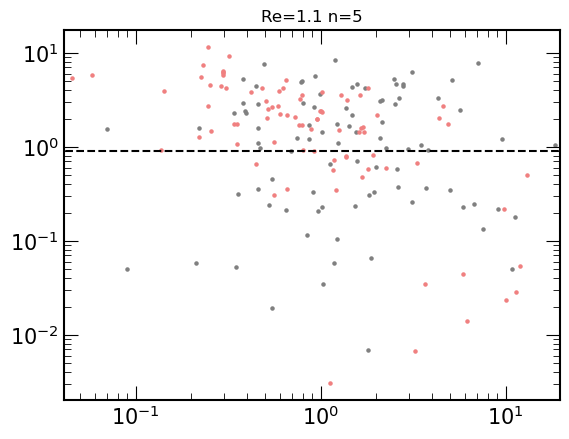

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.510966300964355
5 1.6
finished until t = 0.0 0.8383440971374512
finished until t = 0.5 6.218762636184692
finished until t = 1.0 16.416551113128662
finished until t = 1.5 31.618473291397095
finished until t = 2.0 51.42883586883545
finished until t = 2.5 76.33129096031189
finished until t = 3.0 106.30259919166565
finished until t = 3.5 140.61466717720032
finished until t = 4.0 180.71941542625427
finished until t = 4.5 225.30100774765015
finished until t = 5.0 274.68838572502136
finished until t = 5.5 329.59389638900757
finished until t = 6.0 389.39749455451965
finished until t = 6.5 454.3372447490692
finished until t = 7.0 524.442102432251
finished until t = 7.5 599.7264666557312
finished until t = 8.0 679.8198554515839
finished until t = 8.5 765.4085247516632
finished until t = 9.0 856.303457736969
finished until t = 9.5 952.2202293872833
finished until t = 10.0 1051.6048913002014


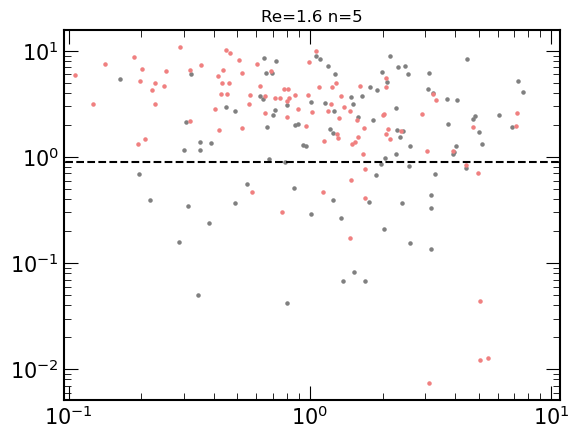

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.509775876998901
5 2.1
finished until t = 0.0 0.787930965423584
finished until t = 0.5 6.00094199180603
finished until t = 1.0 15.867847204208374
finished until t = 1.5 30.18375873565674
finished until t = 2.0 49.25730037689209
finished until t = 2.5 72.87749552726746
finished until t = 3.0 101.27048015594482
finished until t = 3.5 134.17591643333435
finished until t = 4.0 171.69872546195984
finished until t = 4.5 214.06910276412964
finished until t = 5.0 260.9696707725525
finished until t = 5.5 312.91217255592346
finished until t = 6.0 369.5862967967987
finished until t = 6.5 430.488312959671
finished until t = 7.0 496.0632221698761
finished until t = 7.5 566.7743926048279
finished until t = 8.0 642.1021177768707
finished until t = 8.5 722.3797428607941
finished until t = 9.0 808.175797700882
finished until t = 9.5 897.7937054634094
finished until t = 10.0 993.2682571411133


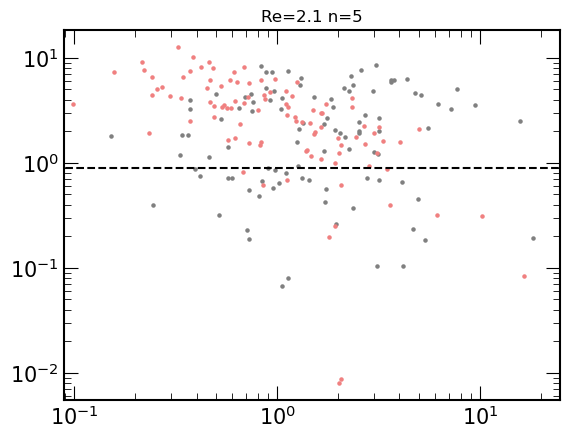

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.298020362854004
5 2.6
finished until t = 0.0 0.8403429985046387
finished until t = 0.5 7.312820911407471
finished until t = 1.0 18.898895025253296
finished until t = 1.5 35.68905019760132
finished until t = 2.0 57.83289313316345
finished until t = 2.5 85.70467829704285
finished until t = 3.0 119.13020610809326
finished until t = 3.5 157.74006414413452
finished until t = 4.0 201.5359330177307
finished until t = 4.5 251.48891806602478
finished until t = 5.0 306.2032301425934
finished until t = 5.5 366.53908824920654
finished until t = 6.0 432.4978132247925
finished until t = 6.5 503.53593587875366
finished until t = 7.0 580.7173054218292
finished until t = 7.5 663.4242196083069
finished until t = 8.0 752.131908416748
finished until t = 8.5 838.6446628570557
finished until t = 9.0 929.1508507728577
finished until t = 9.5 1025.004529953003
finished until t = 10.0 1126.6230382919312


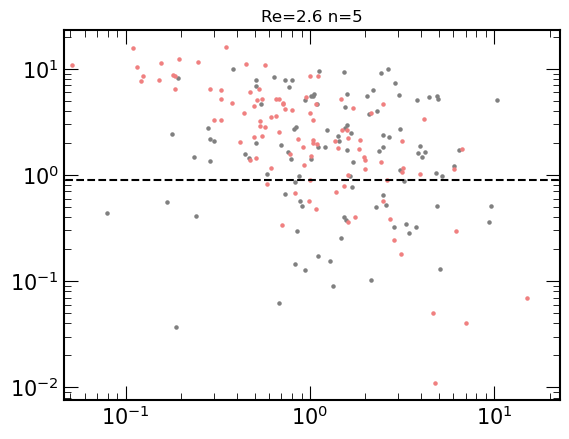

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.4959022998809814
5 3.1
finished until t = 0.0 0.8095626831054688
finished until t = 0.5 7.190019607543945
finished until t = 1.0 18.197339296340942
finished until t = 1.5 34.80610918998718
finished until t = 2.0 56.23690223693848
finished until t = 2.5 83.02518701553345
finished until t = 3.0 114.81305146217346
finished until t = 3.5 151.70849466323853
finished until t = 4.0 193.34569358825684
finished until t = 4.5 239.23485255241394
finished until t = 5.0 291.2516679763794
finished until t = 5.5 347.73355770111084
finished until t = 6.0 409.2441165447235
finished until t = 6.5 475.7454442977905
finished until t = 7.0 547.2377064228058
finished until t = 7.5 617.6553981304169
finished until t = 8.0 691.5084443092346
finished until t = 8.5 769.7082922458649
finished until t = 9.0 852.931070804596
finished until t = 9.5 940.3977537155151
finished until t = 10.0 1032.8653402328491


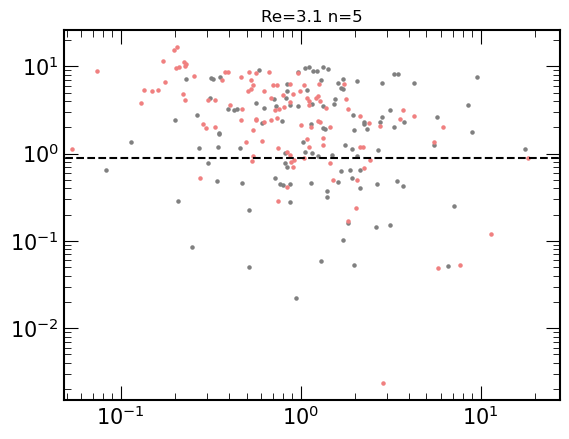

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.549953460693359
5 3.6
finished until t = 0.0 0.6549422740936279
finished until t = 0.5 4.988076686859131
finished until t = 1.0 13.121221542358398
finished until t = 1.5 25.102060079574585
finished until t = 2.0 40.82143807411194
finished until t = 2.5 60.07947134971619
finished until t = 3.0 83.02570223808289
finished until t = 3.5 109.6694393157959
finished until t = 4.0 140.10864782333374
finished until t = 4.5 174.27484345436096
finished until t = 5.0 212.20935916900635
finished until t = 5.5 253.8722472190857
finished until t = 6.0 299.2584080696106
finished until t = 6.5 348.4140796661377
finished until t = 7.0 401.8102819919586
finished until t = 7.5 453.13113617897034
finished until t = 8.0 506.6198215484619
finished until t = 8.5 563.5937612056732
finished until t = 9.0 624.1235480308533
finished until t = 9.5 688.2086563110352
finished until t = 10.0 755.9318306446075


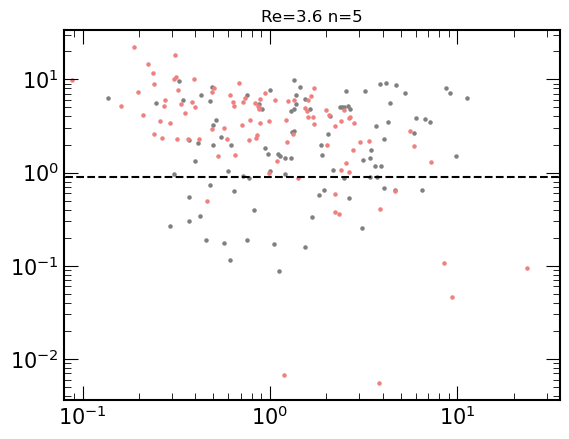

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.100441932678223
5 4.1
finished until t = 0.0 0.5818414688110352
finished until t = 0.5 4.708378076553345
finished until t = 1.0 12.489708185195923
finished until t = 1.5 23.954357862472534
finished until t = 2.0 39.02363109588623
finished until t = 2.5 57.7284631729126
finished until t = 3.0 80.13289618492126
finished until t = 3.5 106.2881019115448
finished until t = 4.0 136.18275141716003
finished until t = 4.5 170.07303929328918
finished until t = 5.0 207.69513249397278
finished until t = 5.5 248.90981149673462
finished until t = 6.0 294.0573706626892
finished until t = 6.5 343.0098166465759
finished until t = 7.0 396.2212245464325
finished until t = 7.5 448.2600517272949
finished until t = 8.0 501.9447672367096
finished until t = 8.5 559.277939081192
finished until t = 9.0 618.6240885257721
finished until t = 9.5 681.1730122566223
finished until t = 10.0 748.6011161804199


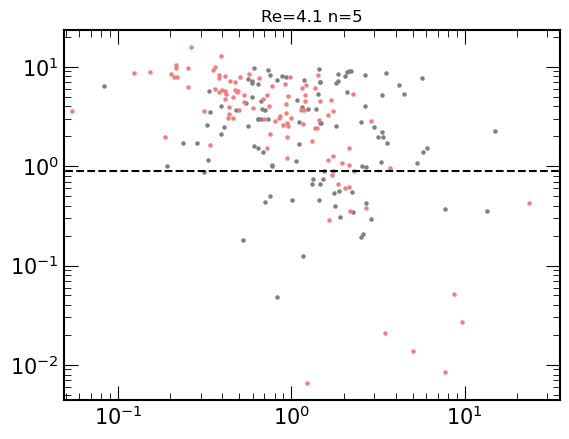

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
5.0475921630859375
5 4.6
finished until t = 0.0 0.44222211837768555
finished until t = 0.5 3.2702012062072754
finished until t = 1.0 8.566992998123169
finished until t = 1.5 16.30183243751526
finished until t = 2.0 26.552512407302856
finished until t = 2.5 39.39915108680725
finished until t = 3.0 55.068540811538696
finished until t = 3.5 73.27424764633179
finished until t = 4.0 94.0803575515747
finished until t = 4.5 117.46563696861267
finished until t = 5.0 143.4675509929657
finished until t = 5.5 171.04231023788452
finished until t = 6.0 200.9794521331787
finished until t = 6.5 233.5393545627594
finished until t = 7.0 268.63637042045593
finished until t = 7.5 306.02325415611267
finished until t = 8.0 345.9409329891205
finished until t = 8.5 388.79771280288696
finished until t = 9.0 432.2785174846649
finished until t = 9.5 480.2337644100189
finished until t = 10.0 528.0846083164215


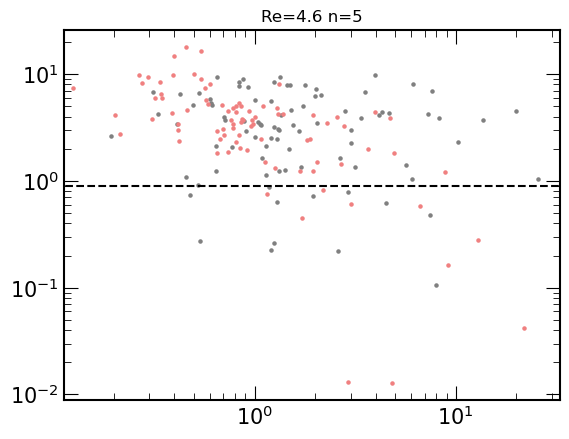

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
4.76931095123291
5 5.1
finished until t = 0.0 0.41443657875061035
finished until t = 0.5 3.0313522815704346
finished until t = 1.0 7.852722406387329
finished until t = 1.5 15.005356788635254
finished until t = 2.0 24.366647481918335
finished until t = 2.5 35.964987993240356
finished until t = 3.0 49.82627534866333
finished until t = 3.5 66.11727666854858
finished until t = 4.0 84.53379726409912
finished until t = 4.5 105.43828558921814
finished until t = 5.0 128.6470432281494
finished until t = 5.5 154.39453649520874
finished until t = 6.0 182.35675477981567
finished until t = 6.5 214.57589197158813
finished until t = 7.0 248.68155717849731
finished until t = 7.5 285.4908974170685
finished until t = 8.0 324.05124044418335
finished until t = 8.5 364.71502470970154
finished until t = 9.0 407.5328195095062
finished until t = 9.5 452.6025915145874
finished until t = 10.0 500.8819434642792


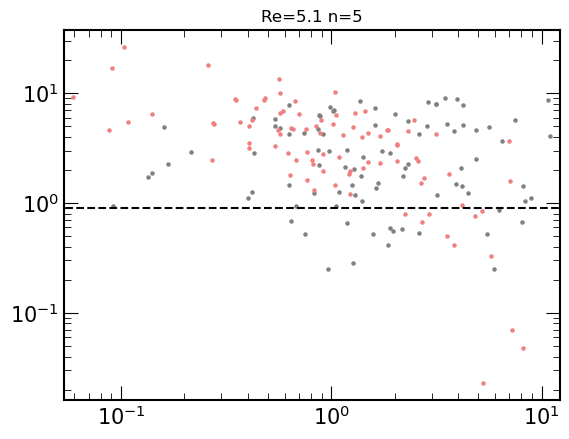

In [3]:
#NFW
R_e_values = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1]
n_values = [5]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             

In [3]:
# NFW ergodic distribution function, calling helpers from NFW_profile_functions.py

######################################
# MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
######################################

rho_0_NFW = 11.82 # 10^5 solar masses / kpc^3
r_0_NFW = 19.54 # kpc
G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
Sersic_params_NFW = [0.9, 1.18]

@np.vectorize
def NFW_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating NFW Energies and Weights')
energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
#E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
print('Finished calculating NFW Energies and Weights')
print(time.time()-start)

# Burkert ergodic distribution function, calling helpers from Burkert_profile_functions.py
rho_0_Burkert = 318.76 # 10^5 solar masses / kpc^3
r_0_Burkert = 3.36 # kpc
Sersic_params_Burkert = [0.9, 1.18]

@np.vectorize
def Burkert_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_Burkert(r, rho_0_Burkert, r_0_Burkert))
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_Burkert(r_psi(psi), rho_0_Burkert, r_0_Burkert, Sersic_params_Burkert[0], Sersic_params_Burkert[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating Burkert Energies and Weights')
energy_values_Burkert = np.pi**2 * G * rho_0_Burkert * r_0_Burkert**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_Burkert = Burkert_ergodic_f(energy_values_Burkert)
#E_dist_Burkert = [energy_values_Burkert, energy_weights_Burkert]
print('Finished calculating Burkert Energies and Weights')
print(time.time()-start)

# making interpolated functions for f(E) that can be called in the initialization process for speed

#def NFW_f_interp(E):
 #   return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

#def Burkert_f_interp(E):
 #
    #return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
15.799822330474854
Calculating Burkert Energies and Weights
Finished calculating Burkert Energies and Weights
15.203827619552612


In [4]:
# saves outputs for every 0.5 Gyr
#R_e_values = np.arange(1.6, 10.1, 0.5)
n_values = [5]
R_e_values = [1.6, 2.1]
#n_values = [1, 4]

def NFW_f_interp(E):
    return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

def Burkert_f_interp(E):
    return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


def run_sim(potential, force, halo_params, ergodic_f, seed, t):
    
    start = time.time()
    
    np.random.seed(seed)
    
    # usual initialization of the sim, units, etc.
    sim = rebound.Simulation()
    sim.ri_ias15.epsilon = 0 # using fixed timesteps
    #sim.ri_ias15.min_dt = 1e-5
    #sim.ri_ias15.max_dt = 1e-3
    sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
    sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
    sim.softening = 0.01 # plummer softening of 10 pc
    sim.collision = "line" # counting collisions as linear interpolations between timesteps
    sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
    # Sersic radial distribution and values to draw positions with their weights
    
    pos_values = np.arange(1e-4, 10, 1e-4)
    pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
    pos_weights /= sum(pos_weights)
    
    # unpacking halo params
    rho_0 = halo_params[0]
    r_0 = halo_params[1]
    
    # setting up a mass function gaussian in logM
    logmass_values = np.linspace(-2, 2, 1000)
    logmass_weights = mass_function(logmass_values)
    logmass_weights /= sum(logmass_weights)
    
    total_GC_mass = 0
    # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
    while total_GC_mass < UGC7369_total_mass-10**(4.987311450993631 - 5):
        mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
        pos_rad = np.random.choice(pos_values, p=pos_weights)
        pos_theta = np.random.uniform(0, np.pi)
        pos_phi = np.random.uniform(0, 2*np.pi)
        x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
        y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
        z_i = pos_rad*np.cos(pos_theta)

        # drawing velocities from provided distribution
        vel_values = np.arange(0.01, 100, 0.01)
        vel_weights = 4*np.pi*vel_values**2 * \
                        ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
        vel_weights /= sum(vel_weights)
        vel_mag = np.random.choice(vel_values, p=vel_weights)
        v_theta = np.random.uniform(0, np.pi)
        v_phi = np.random.uniform(0, 2*np.pi)
        vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
        vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
        vz_i = vel_mag * np.cos(v_theta)
        
        sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
        total_GC_mass += mass/np.exp(10/23)
    
    rebx = reboundx.Extras(sim)
    # adding in the additional forces to work with reboundx
    myforce = rebx.create_force("additional_forces")
    myforce.force_type = "vel"
    myforce.update_accelerations = force
    rebx.add_force(myforce)
    # setting up built-in exponential mass loss
    modifymass = rebx.load_operator("modify_mass")
    rebx.add_operator(modifymass)
    # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
    for p in sim.particles:
        p.params["tau_mass"] = -23
    
    # keeping track of initial positions, velocities, and masses
    initial_masses = []
    initial_positions = []
    initial_vels = []

    for p in sim.particles:
        initial_masses.append(p.m)
        initial_positions.append(np.array([p.x, p.y, p.z]))
        initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    # integrating
    sim.integrate(t)
    
    # keeping track of final positions, velocities, and masses
    final_masses = []
    final_positions = []
    final_vels = []

    for p in sim.particles:
        final_masses.append(p.m)
        final_positions.append(np.array([p.x, p.y, p.z]))
        final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
    initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
    initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
    # clearing sim from memory now that we've stored everything important
    sim = None
    
    # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
    return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]

In [5]:
# run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
    seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
    start = time.time()
    
    for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
        
        if output_time == 0:
            # save initial data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=0.001)
                for GC_n in range(len(masses[0])):
                    f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                            +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                            +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                            +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        else:
            # save final data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=t)
                for GC_n in range(len(masses[1])):
                    f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        print('finished until t = '+str(t), str(time.time()-start))

finished until t = 0.0 2.7682409286499023
finished until t = 0.5 91.24297428131104
finished until t = 1.0 257.8840882778168
finished until t = 1.5 505.1742823123932
finished until t = 2.0 832.7858872413635
finished until t = 2.5 1240.9750459194183
finished until t = 3.0 1729.2798323631287
finished until t = 3.5 2297.6773710250854
finished until t = 4.0 2944.9405615329742
finished until t = 4.5 3669.5551850795746
finished until t = 5.0 4472.634169101715
finished until t = 5.5 5354.438955068588
finished until t = 6.0 6312.469014883041
finished until t = 6.5 7331.466467380524
finished until t = 7.0 8429.072170734406
finished until t = 7.5 9597.940333366394
finished until t = 8.0 10847.780881881714
finished until t = 8.5 12178.797756433487
finished until t = 9.0 13585.149750947952
finished until t = 9.5 15070.488186836243
finished until t = 10.0 16626.485266923904


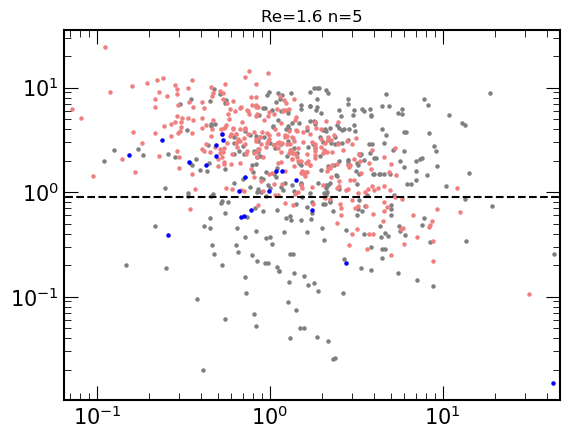

finished until t = 0.0 1.9471397399902344
finished until t = 0.5 89.09460163116455
finished until t = 1.0 247.45654582977295
finished until t = 1.5 471.2455496788025
finished until t = 2.0 768.2841794490814
finished until t = 2.5 1139.3175964355469
finished until t = 3.0 1581.3754398822784
finished until t = 3.5 2094.7920801639557
finished until t = 4.0 2676.9806282520294
finished until t = 4.5 3330.4960980415344
finished until t = 5.0 4054.813821554184
finished until t = 5.5 4849.521659612656
finished until t = 6.0 5716.090933084488
finished until t = 6.5 6651.752789735794
finished until t = 7.0 7657.179158210754
finished until t = 7.5 8732.590750694275
finished until t = 8.0 9876.759744167328
finished until t = 8.5 11091.257192850113
finished until t = 9.0 12373.718080997467
finished until t = 9.5 13724.321380615234
finished until t = 10.0 15107.765540838242


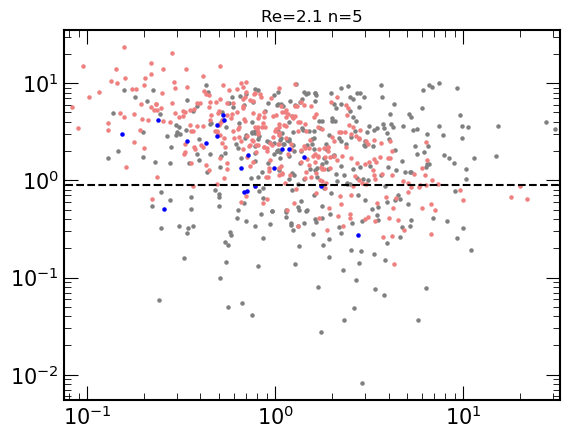

In [6]:
#Burket
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'Burkert-1', phi_Burkert, clib_additional_forces.Burkert_DF_Petts, [318.76, 3.36], Burkert_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('Burkert-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()

finished until t = 0.0 3.298001766204834
finished until t = 0.5 27.2284677028656
finished until t = 1.0 69.6914873123169
finished until t = 1.5 129.10802006721497
finished until t = 2.0 204.62902116775513


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 2.5 294.5320460796356
finished until t = 3.0 398.80593085289
finished until t = 3.5 518.4169380664825
finished until t = 4.0 652.2765417098999
finished until t = 4.5 800.8241581916809
finished until t = 5.0 962.4037802219391
finished until t = 5.5 1135.5897767543793
finished until t = 6.0 1323.1900308132172
finished until t = 6.5 1523.529489994049
finished until t = 7.0 1737.2329769134521
finished until t = 7.5 1962.7301552295685
finished until t = 8.0 2199.235008955002
finished until t = 8.5 2451.4149940013885
finished until t = 9.0 2709.908364534378
finished until t = 9.5 2959.1320490837097
finished until t = 10.0 3221.3054146766663


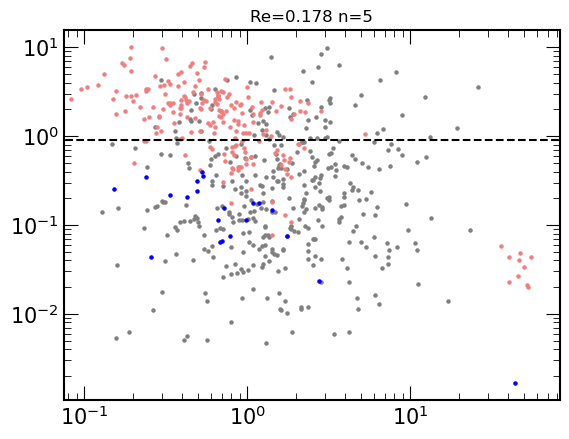

finished until t = 0.0 1.8810224533081055
finished until t = 0.5 24.165206909179688
finished until t = 1.0 65.78522682189941
finished until t = 1.5 126.78329277038574
finished until t = 2.0 204.4772629737854
finished until t = 2.5 299.24717688560486
finished until t = 3.0 410.90367889404297
finished until t = 3.5 536.8479287624359
finished until t = 4.0 677.382509469986
finished until t = 4.5 834.3590598106384
finished until t = 5.0 1005.2720456123352
finished until t = 5.5 1180.2528295516968
finished until t = 6.0 1364.3988628387451
finished until t = 6.5 1552.1953587532043
finished until t = 7.0 1717.9430844783783
finished until t = 7.5 1888.7141001224518
finished until t = 8.0 2063.6350059509277
finished until t = 8.5 2250.2398598194122
finished until t = 9.0 2447.2746086120605
finished until t = 9.5 2648.8848316669464
finished until t = 10.0 2844.95654296875


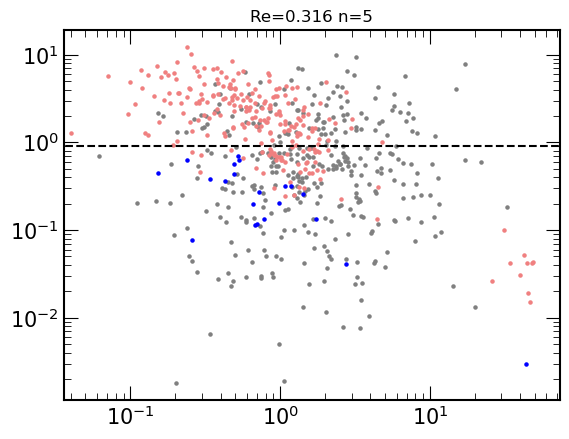

In [6]:
#NFW
R_e_values = [0.178, 0.316]
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'NFW-1', phi_NFW, clib_additional_forces.NFW_DF_Petts, [11.82, 19.54], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
          